In [1]:
import sys
import os

# Get the absolute path to the project directory
project_dir = os.path.abspath("..")

# Append the project directory to sys.path
if project_dir not in sys.path:
    sys.path.append(project_dir)

In [2]:
import yfinance as yf
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import msgpack
import warnings
from dataclasses import asdict, is_dataclass, dataclass
import os
import msgpack
import json
import pickle
from pandas.api.types import is_datetime64_any_dtype
import scipy
import numpy as np
import polars as pl
from scipy.stats import linregress
from typing import Dict, List
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


from src.common.AssetData import AssetData
from src.common.AssetDataPolars import AssetDataPolars
from src.common.AssetDataService import AssetDataService
from src.common.AssetFileInOut import AssetFileInOut 
from src.databaseService.OutsourceLoader import OutsourceLoader

from src.simulation.SimulatePortfolio import SimulatePortfolio
from src.strategy.StratBuyAndHold import StratBuyAndHold
from src.simulation.ResultAnalyzer import ResultAnalyzer
from src.common.AssetFileInOut import AssetFileInOut
from src.mathTools.CurveAnalysis import CurveAnalysis
from src.mathTools.SeriesExpansion import SeriesExpansion
from src.predictionModule.FourierML import FourierML
from src.common.YamlTickerInOut import YamlTickerInOut
from src.common.DataFrameTimeOperations import DataFrameTimeOperationsPandas as DFTO


In [3]:
assets=AssetFileInOut("../src/stockGroups/bin").loadDictFromFile("group_snp500_over20years")

# Convert to Polars for speedup
assetspl: Dict[str, AssetDataPolars] = {}
for ticker, asset in assets.items():
    assetspl[ticker]= AssetDataService.to_polars(asset)

In [4]:
ticker ="MMM"
aIRM = assetspl[ticker]
pricesArray = aIRM.adjClosePrice["AdjClose"]
currDatediff = 500*5
aidx = len(pricesArray) - currDatediff
pastPrices = pricesArray.slice(aidx-24 * 21, 24 * 21 +1).to_numpy()

aIRM.adjClosePrice["Date"].item(aidx)

datetime.datetime(2014, 11, 19, 0, 0)

In [5]:
startDate=pd.Timestamp(year=2019, month=9, day=4)
endDate=pd.Timestamp(year=2020, month=1, day=4)
fourierTestML = FourierML(assetspl, startDate, endDate)

fourierTestML.prepareData()

Processing asset: MMM.  Processed 0 out of 390.
Processing asset: AOS.  Processed 1 out of 390.
Processing asset: ABT.  Processed 2 out of 390.
Processing asset: ACN.  Processed 3 out of 390.
Processing asset: AES.  Processed 4 out of 390.
Processing asset: AFL.  Processed 5 out of 390.
Processing asset: A.  Processed 6 out of 390.
Processing asset: APD.  Processed 7 out of 390.
Processing asset: ALB.  Processed 8 out of 390.
Processing asset: ARE.  Processed 9 out of 390.
Processing asset: LNT.  Processed 10 out of 390.
Processing asset: ALL.  Processed 11 out of 390.
Processing asset: MO.  Processed 12 out of 390.
Processing asset: AEE.  Processed 13 out of 390.
Processing asset: AEP.  Processed 14 out of 390.
Processing asset: AXP.  Processed 15 out of 390.
Processing asset: AIG.  Processed 16 out of 390.
Processing asset: AMT.  Processed 17 out of 390.
Processing asset: AME.  Processed 18 out of 390.
Processing asset: APH.  Processed 19 out of 390.
Processing asset: AON.  Processed

C:\Users\KILightTouch\AppData\Local\Temp\ipykernel_3564\1844540972.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=fourierTestML.y, palette='viridis')


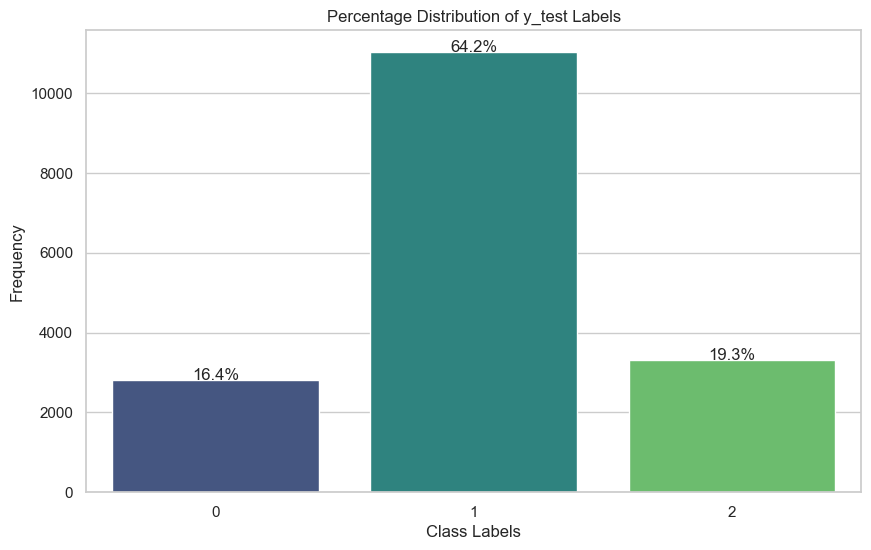

0.47705685146244586


In [6]:
sns.set(style="whitegrid")

plt.figure(figsize=(10,6))
total = len(fourierTestML.y)
sns.countplot(x=fourierTestML.y, palette='viridis')

# Add percentage labels on top of each bar
percentage= []
for p in plt.gca().patches:
    perc = '{:.1f}%'.format(100 * p.get_height() / total)
    percentage.append(p.get_height() / total)
    height = p.get_height()
    plt.gca().text(p.get_x() + p.get_width()/2., height + 1, perc, ha="center") 

plt.title('Percentage Distribution of y_test Labels')
plt.xlabel('Class Labels')
plt.ylabel('Frequency')
plt.show()

percentage= np.array(percentage)
print(np.sum(percentage ** 2))

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(fourierTestML.X, fourierTestML.y, test_size=.2)
input_shape = X_train.shape[1]
output_shape = 2*1+1
num_classes = len(np.unique(fourierTestML.y))
y_cat_train = to_categorical(y_train, num_classes)
y_cat_test = to_categorical(y_test, num_classes)

fourierTestCNNModel = models.Sequential()
# Define the model
fourierTestCNNModel = models.Sequential([
            layers.Dense(64, activation='relu', input_shape=(input_shape,)),
            layers.Dropout(0.2),
            layers.Dense(16, activation='relu'),
            layers.Dense(output_shape, activation='softmax')
])

fourierTestCNNModel.compile(optimizer='adam',
                              loss='categorical_crossentropy',
                              metrics=['accuracy'])

history = fourierTestCNNModel.fit(X_train, y_cat_train,
                                    epochs=40,
                                    batch_size=64,
                                    validation_split=0.1,
                                    verbose=2)

Epoch 1/40


c:\Users\KILightTouch\Desktop\RandomOdyssey\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


194/194 - 1s - 6ms/step - accuracy: 0.6376 - loss: 0.9308 - val_accuracy: 0.6417 - val_loss: 0.8906
Epoch 2/40
194/194 - 0s - 1ms/step - accuracy: 0.6441 - loss: 0.8876 - val_accuracy: 0.6431 - val_loss: 0.8876
Epoch 3/40
194/194 - 0s - 1ms/step - accuracy: 0.6444 - loss: 0.8864 - val_accuracy: 0.6446 - val_loss: 0.8850
Epoch 4/40
194/194 - 0s - 1ms/step - accuracy: 0.6441 - loss: 0.8850 - val_accuracy: 0.6453 - val_loss: 0.8841
Epoch 5/40
194/194 - 0s - 1ms/step - accuracy: 0.6448 - loss: 0.8840 - val_accuracy: 0.6446 - val_loss: 0.8798
Epoch 6/40
194/194 - 0s - 989us/step - accuracy: 0.6448 - loss: 0.8826 - val_accuracy: 0.6446 - val_loss: 0.8817
Epoch 7/40
194/194 - 0s - 971us/step - accuracy: 0.6448 - loss: 0.8816 - val_accuracy: 0.6438 - val_loss: 0.8777
Epoch 8/40
194/194 - 0s - 982us/step - accuracy: 0.6444 - loss: 0.8811 - val_accuracy: 0.6431 - val_loss: 0.8761
Epoch 9/40
194/194 - 0s - 986us/step - accuracy: 0.6448 - loss: 0.8823 - val_accuracy: 0.6431 - val_loss: 0.8762
Epoc

In [31]:
fourierML = FourierML(assetspl, pd.Timestamp(None), pd.Timestamp(None))
fourierML.loadCNNModel("../src/predictionModule/bin", "fourierML_snp500_10to20.keras")

Model loaded successfully


In [32]:
features = fourierML.getFeaturesFromPrice(pastPrices/pastPrices[-1], multFactor=32, fouriercutoff=200)
features = np.array(features)

In [33]:
features = features.reshape(1, -1)
predArr = fourierML.CNNModel.predict(np.array(features))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


In [34]:
classificationInterval = [0.001,0.003,0.007,0.011,0.016,0.022,0.03,0.05,0.075,0.1]
print(predArr.flatten())
predicted_class_index = np.argmax(predArr, axis=1)[0]

print(predicted_class_index)
print(predicted_class_index - 10)

[3.1233311e-04 1.8255463e-05 6.4763534e-03 1.3151542e-02 1.5685750e-02
 2.3439447e-04 6.0431831e-02 2.4542932e-03 5.5588377e-03 7.3244298e-01
 1.6966673e-02 2.8498763e-01 3.8723320e-02 2.0313815e-03 8.6346902e-03
 1.7278139e-02 1.6804645e-02 5.9018019e-03 2.9041019e-04 4.0679955e-05
 1.7374216e-04]
9
-1


In [36]:
print(pricesArray.item(aidx+2))
print(pricesArray.item(aidx))
pricesArray.item(aidx+2)/pricesArray.item(aidx+0)

96.10368347167969
95.3056411743164


1.0083735053615939